In [1]:
import os
from pathlib import Path
from typing import Optional

import fastmri
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from data_utils import *
from datasets import *
from fastmri.data.transforms import tensor_to_complex_np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torch.utils.data import DataLoader, TensorDataset

from model import *
from torch.optim import SGD, Adam, AdamW
from train_utils import *

In [ ]:
model_checkpoint = '/scratch_net/ken/mcrespo/proj_marina/logs/multivol/2024-11-13_12h31m52s/checkpoints/epoch_0999.pt'  # TODO: SET (OR LEAVE COMMENTED).
files = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'


dataset = KCoordDataset(files, n_volumes=3, n_slices=3, with_mask=False)
print(len(dataset))
# loader_config = config["dataloader"]
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, collate_fn=collate_fn, pin_memory=PIN_MEMORY, worker_init_fn=seed_worker, generator=RS_TORCH)


13493760


In [4]:
gamma = 0.1
sigma = 0.01
lr = 5.e-6
embedding_dim = 512

OPTIMIZER_CLASSES = {
    "Adam": Adam,
    "AdamW": AdamW,
    "SGD": SGD,
}

LOSS_CLASSES = {
    "MAE": MAELoss,
    "DMAE": DMAELoss,
    "MSE": MSELoss,
    "MSEDist": MSEDistLoss,
    "HDR": HDRLoss,
    "LogL2": LogL2Loss,
    "MSEL2": MSEL2Loss,
}


model = Siren(hidden_dim=512, levels=5, embedding_dim=512, n_min=45, n_layers=6, out_dim=2, dropout_rate=0)
# Load checkpoint.
model_state_dict = torch.load(model_checkpoint,  map_location=torch.device('cpu'))["model_state_dict"]
model.load_state_dict(model_state_dict)
print("Checkpoint loaded successfully.")

# Only embeddings are optimized.
for param in model.parameters():
    param.requires_grad = False



embeddings = torch.nn.Embedding(
    len(dataset.metadata), embedding_dim
)
torch.nn.init.normal_(
    embeddings.weight.data, 0.0, sigma
)
optimizer = OPTIMIZER_CLASSES["Adam"](
    embeddings.parameters(), lr
)

loss_fn = LOSS_CLASSES["MSEL2"](gamma, sigma)

/tmp/ipykernel_24629/460602625.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_checkpoint,  map_location=torch.device('cpu'))["model

Checkpoint loaded successfully.


In [5]:
from pathlib import Path
import fastmri
from fastmri.data.subsample import EquiSpacedMaskFunc, RandomMaskFunc

path_to_data = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'
n_volumes = 1
center_frac = 0.15
acceleration = 4
n_slices = 2
with_mask = True

path_to_data = Path(path_to_data)
if path_to_data.is_dir():
    files = sorted(
        [
            file
            for file in path_to_data.iterdir()
            if file.suffix == ".h5" and "AXT1POST_205" in file.name
        ]
    )[:n_volumes]
else:
    files = [path_to_data]

# For each MRI volume in the dataset...
for vol_id, file in enumerate(files):
    # Load MRI volume
    with h5py.File(file, "r") as hf:
        volume_kspace = to_tensor(preprocess_kspace(hf["kspace"][()]))[
            :n_slices
        ]


In [7]:
with_mask = False
mask_func = EquiSpacedMaskFunc(
    center_fractions=[center_frac], accelerations=[acceleration]
)
shape = (1,) * len(volume_kspace.shape[:-3]) + tuple(
    volume_kspace.shape[-3:]
)
mask, _ = mask_func(
    shape, None, vol_id
)  # use the volume index as random seed.

mask, left_idx, right_idx = remove_center(mask)

n_slices, n_coils, height, width = volume_kspace.shape[:-1]

if with_mask:
    kx_ids = torch.where(mask.squeeze())[0]
else:
    kx_ids = torch.from_numpy(np.setdiff1d(np.arange(width), np.arange(left_idx, right_idx))) # NOTE: Uncomment to include all the datapoints (fully-sampled volume), with the exception of the center region.
kx_ids = torch.arange(width)
ky_ids = torch.arange(height)
kz_ids = torch.arange(n_slices)
coil_ids = torch.arange(n_coils)

kspace_ids = torch.meshgrid(kx_ids, ky_ids, kz_ids, coil_ids, indexing="ij")
kspace_ids = torch.stack(kspace_ids, dim=-1).reshape(-1, len(kspace_ids))

##################################################
# Computing the inputs
##################################################
# Convert indices into normalized coordinates in [-1, 1].
kspace_coords = torch.zeros((kspace_ids.shape[0], 4), dtype=torch.float)
kspace_coords[:, :2] = kspace_ids[:, :2]

kspace_coords[:, 2] = (2 * kspace_ids[:, 2]) / (n_slices - 1) - 1
kspace_coords[:, 3] = (2 * kspace_ids[:, 3]) / (n_coils - 1) - 1

# Used to determine the latent vector (one per volume).
vol_ids = torch.tensor([vol_id] * len(kspace_coords)).unsqueeze(1)

# Appended volume index
# self.inputs.append(torch.cat((vol_ids, kspace_coords), dim=1))

##################################################
# Computing the targets
##################################################
targets = volume_kspace[
    kspace_ids[:, 2], kspace_ids[:, 3], kspace_ids[:, 1], kspace_ids[:, 0]
]


In [15]:
torch.view_as_complex(targets).abs()

tensor([9.0977e-22, 2.3982e-21, 1.0293e-20,  ..., 2.2790e-20, 2.0938e-20,
        3.3247e-20], dtype=torch.float64)

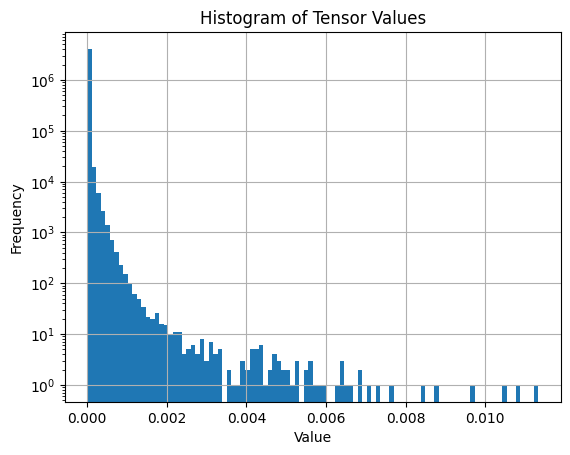

In [22]:
numpy_values = np.abs(torch.view_as_complex(targets).numpy())

# Plot the histogram
plt.hist(numpy_values,  log = True, bins = 100)
plt.title('Histogram of Tensor Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
epsilon = min()
np.log(targets+epsilon)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
dataloader = DataLoader(
    dataset,
    batch_size=120_000,
    num_workers=0,
    shuffle=True,
    pin_memory=False,
    )

for batch_idx, (inputs, targets) in enumerate(dataloader):
    # inputs, targets = inputs.to(self.device), targets.to(self.device)

    # Inputs has dimension Nm x 5, position 0 corresponds to volID
    coords, latent_embeddings = inputs[:, 1:], embeddings(
        inputs[:, 0].long()
    )
    